# Dynamic Mapping (via evomap)

This notebook demonstrates how to use the dynamic mapping framework *EvoMap*. For the methodological background and a detailed description, see our paper [[1]](#ref_1). 

This tutorial covers data preparation, how to run the model, how to evaluate its results, tuning its hyperparameter and several useful functions provided as part of this package (e.g., for creating market maps based on its output).  

For a more condensed overview on how to run *EvoMap* for your own data, see the notebook ***Quickstart.ipynb***. 

## Tutorial Sections

1. [Data Preparation](#section_1)

2. [Running the Model](#section_2)

3. [Exploring Model Output](#section_3)

4. [Evaluating Model Output](#section_4)

5. [Hyperparameter Tuning](#section_5)

6. [Chosing a Different Mapping Method](#section_6)

7. [Special Cases and Extensions](#section_7)


## Background:


**Author:** Maximlian Matthe (matthe@wiwi.uni-frankfurt.de)

**Last updated:** April 2022

*If you use this package or parts of its code, please cite our work*

**References**

<a id = "ref_1">[1]</a> Matthe, M., Ringel, D. M., Skiera, B. (2022), "Mapping Market Structure Evolution", Working Paper.

<a id = "ref_2">[2]</a> Matthe, M. (2022), "marketmaps: A Python Package for Analyzing Markets in Maps", Working Paper.



<a id = 'section_1'></a>
## Data Preparation
First, lead all required imports for this demonstration and set the seed to ensure reproducibility. 

In [1]:
import pandas as pd
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(123) 

For this demonstration, we use a sample of the TNIC data also used in [[1]](#ref_1). The original data is provided at https://hobergphillips.tuck.dartmouth.edu/. The data consists of an edgelist, that is, firm-firm relationships. 

We merge this edgelist with further firm information. The merged data includes the following variables: 

| Variable | Description | Source |
| --- | --- | --- |
| year | Fiscal year | TNIC |
| gvkey | Firm identifier | TNIC |
| score | Similarity score | TNIC |
| name | Firm name | Compustat |
| mkvalt | Market value | Compustat |
| sic | SIC Code | Compustat |

In the final data, each row corresponds to a single firm-firm pair at a specific point in time. Thus, each firm variable appears twice in each row (once for each firm). We provide the merged data on our website, from which you can directly and store it. 

In [2]:
if not os.path.exists("data"):
    os.mkdir("data")
    
if not os.path.exists("data/tnic_sample_merged.csv"):
    df_tnic = pd.read_csv("http://evomap.io/TNIC/tnic_sample/tnic_sample_merged.csv")
    df_tnic.to_csv(r'data/tnic_sample_merged.csv', index = None)
else:
    df_tnic = pd.read_csv(r"data/tnic_sample_merged.csv")

This sample includes more than 1,000 different firms. To simplify our demonstration (and accelerate the runtime of this notebook), we pick a smaller sub-sample from these data. Specifically, we pick the 250 biggest firms (by market value). We then drop those with less than 5 peer firms in any period. You should always make sure that your data includes enough non-zero relationships, as otherwise mapping methods (such as t-SNE) cannot faithfully embed these firms into lower dimensional (e.g., 2D) space. 

In [3]:
sample_firms = df_tnic.sort_values('mkvalt1', ascending = False).name1.unique()[:25]
sample_firms_competitors = np.array([])
for firm in sample_firms:
    comps = df_tnic.query('name1 == @firm').query('year == 1998').sort_values('score', ascending = True).name2.values[:20]
    sample_firms_competitors = np.unique(np.concatenate((sample_firms_competitors, comps)))
    
sample_firms = np.unique(np.concatenate((sample_firms, sample_firms_competitors)))
df_sample = df_tnic.query('name1 in @sample_firms').query('name2 in @sample_firms')

print("Number of firms before pruning: {0}".format(len(sample_firms)))

def get_min_num_neighbors(df):
    """ Get the minimum number of neighbors within the TNIC edgelist across all firms and years. """
    min_neighbors_i = df.groupby(['name1', 'year']).agg({'name2':'nunique'}).groupby('name1').agg('min').min().values
    min_neighbors_j = df.groupby(['name2', 'year']).agg({'name1':'nunique'}).groupby('name2').agg('min').min().values
    return np.minimum(min_neighbors_i, min_neighbors_j)

def get_num_years(df, name):
    return len(df.query('name1 == @name').year.unique())

while get_min_num_neighbors(df_sample) < 3:
    print("Pruning the network..")
    sample_firms = df_sample.groupby(['name1', 'year']).agg({'name2': 'nunique'}).groupby('name1').agg('min').query('name2 >= 3').index.values
    df_sample = df_sample.query('name1 in @sample_firms').query('name2 in @sample_firms')
    sample_firms = [firm for firm in sample_firms if get_num_years(df_sample, firm) == 20]
    df_sample = df_sample.query('name1 in @sample_firms').query('name2 in @sample_firms')
    
display("Final sample size: {0}".format(df_sample.name1.nunique()))

Number of firms before pruning: 376
Pruning the network..
Pruning the network..
Pruning the network..
Pruning the network..


'Final sample size: 275'

The final sample includes:  

In [4]:
display("{0} firms and {1} years".format(df_sample.name1.nunique(), df_sample.year.nunique()))

'275 firms and 20 years'

Finally, we need to turn this edgelist into relationship matrices. Specifically, the expected input for *EvoMap* is a list of numpy arrays, each containing all pairwise relationships at a specific point in time. 

**Important note:** Make sure that each matrix has the same size and that its rows & columns are ordered consistently! If you do not observe certain firms at some points in time (e.g., due to entry or exit), you should provide inclusion vectors (covered [later](#inclusions)).

This package provides some helpful functions for such transformations (see *transformations.py*). 

In [5]:
from evomap.transformations import edgelist2matrix, sim2dist

def build_distance_matrices(df):
    """Turn tnic data from time-indexed edgelist format to a sequence of square distance matrices. """
    years = df['year'].sort_values().unique()
    D_ts = []
    for year in years:
        display("Building matrix for year {0}".format(year))
        S_t, names = edgelist2matrix(
            df = df,
            score_var = 'score',
            id_var_i = 'name1',
            id_var_j = 'name2',
            time_var = 'year',
            time_selected = year)
        D_t = sim2dist(S_t)
        D_ts.append(D_t)
                
    return D_ts, names, years

D_ts, names, years = build_distance_matrices(df_sample)
n_samples = D_ts[0].shape[0]
n_periods = len(D_ts)

'Building matrix for year 1998'

'Building matrix for year 1999'

'Building matrix for year 2000'

'Building matrix for year 2001'

'Building matrix for year 2002'

'Building matrix for year 2003'

'Building matrix for year 2004'

'Building matrix for year 2005'

'Building matrix for year 2006'

'Building matrix for year 2007'

'Building matrix for year 2008'

'Building matrix for year 2009'

'Building matrix for year 2010'

'Building matrix for year 2011'

'Building matrix for year 2012'

'Building matrix for year 2013'

'Building matrix for year 2014'

'Building matrix for year 2015'

'Building matrix for year 2016'

'Building matrix for year 2017'

<a id = 'section_2'></a>
## Running the Model

First, fix a random starting initialization. While doing so is not strictly necessary, it is good practice - especially when one wants to compare the derived maps to solutions by other approaches. 

In [6]:
Y_init = np.random.normal(0.0,1.0,size=(n_samples,2))
Y_init_ts = [Y_init]*n_periods

Then, choose a value for the hyperparamter alpha and run the model. We will cover ways how to identify appropriate values for EvoMap's hyperparameters [later](#section_5)

In [7]:
from evomap.EvoTSNE import EvoTSNE

EvoMap = EvoTSNE(
    init = Y_init_ts,
    alpha = 0.001)

Y_ts = EvoMap.fit_transform(D_ts)

The output is a list of map coordinates, each stored in a ndarray of shape (n_samples, d), where d is typically = 2. 

This package provides multiple tools to explore these results. Here, we look at the first 4 maps as a sequence. We cover more advanced alternatives for exploration in [Section 3: Exploring Model Output](#section_3).

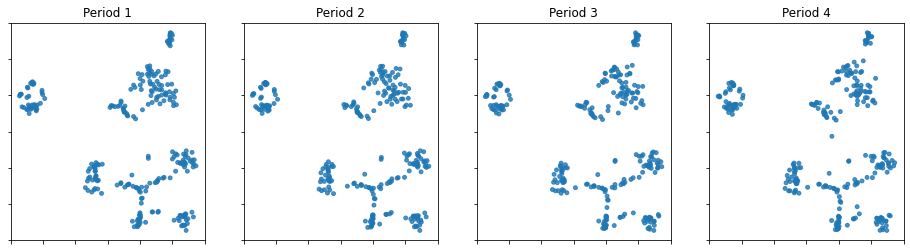

In [8]:
from evomap.printer import draw_map_sequence

draw_map_sequence(Y_ts[:4])

<a id = 'section_3'></a>
## Exploring Model Output

This package provides three ways to explore EvoMap's output: 

1. [Draw a static map](#static_map)
2. [Draw a sequence of static maps](#sequence)
3. [Draw a dynamic map](#dynamic_map) (i.e., an overlay of subsequent maps)

All necessary functions are included in the "printer" module and provide lots of flexibility to adjust their aesthetics.

<a id = 'static_map'></a>
### Draw a Static Map

To draw a single static map, simply use the corresponding function ```draw_map()```.

<AxesSubplot:>

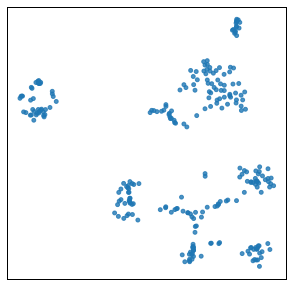

In [9]:
from evomap.printer import draw_map

draw_map(Y_ts[0])

Aesthetics of the map can easily be adjusted via additional arguments. For instance, if class labels are available (e.g., obtained via clustering or additional metadata), they can be added as colors. Here, we can use SIC codes for coloring:

<AxesSubplot:>

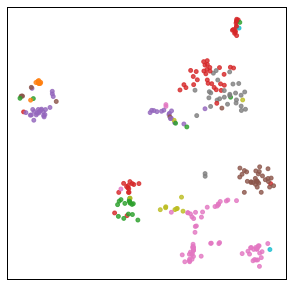

In [10]:
sic_codes = pd.DataFrame({'name1' : names}).merge(df_sample[['name1', 'sic1']], on = 'name1', how = 'left').drop_duplicates('name1')['sic1'].map(lambda x: str(x)[:1]).values
draw_map(Y_ts[0], c = sic_codes)


One can further annotate the map, using clusters

C:\Users\MPMATTHE\Anaconda3\envs\evomap-replication-env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  """Entry point for launching an IPython kernel.
C:\Users\MPMATTHE\Anaconda3\envs\evomap-replication-env\lib\site-packages\numpy\core\fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


<AxesSubplot:>

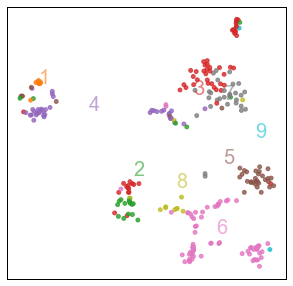

In [11]:
draw_map(Y_ts[0], c = sic_codes, annotate = 'clusters')

or labels. Note that one can also use additional keyword arguments to adjust the plot and its labels further. 

<AxesSubplot:>

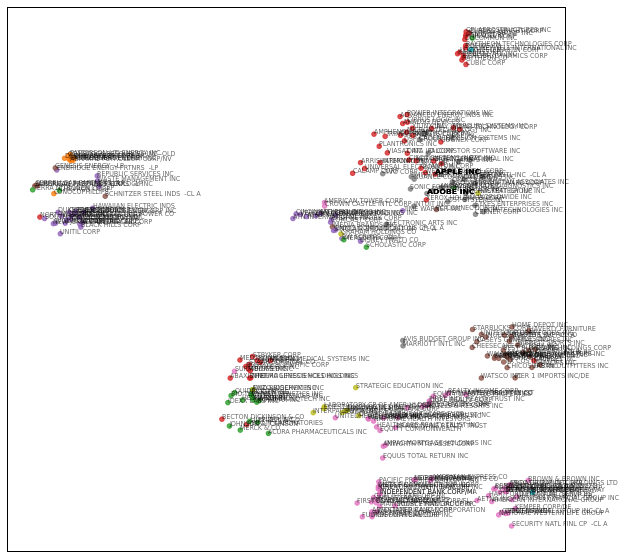

In [12]:
draw_map(
    Y_ts[0], 
    c = sic_codes, 
    annotate = 'labels', 
    labels = names, 
    highlight_labels = ['APPLE INC', 'ADOBE INC'],
    fig_size = (10,10),
    fontdict = {'size': 8},
    scatter_kws = {'s' : 20})

<a id = 'sequence'></a>
### Draw a Sequence of Maps

Rather than drawing a single map, one can also draw a sequence via ```draw_map_sequence()```.

The function takes a list of ndarrays (each containing the map coordinates for one period) and creates a map for each of them:

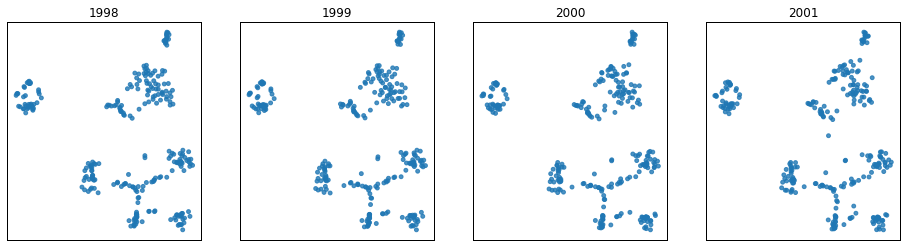

In [13]:
from evomap.printer import draw_map_sequence
draw_map_sequence(Y_ts[:4], n_cols = 4, time_labels = years)

Map aesthetics can be adjusted analogously to drawing a static map. To do so, simply provide arguments of ```draw_map()``` as keyword arguments to ```draw_map_sequence()```:

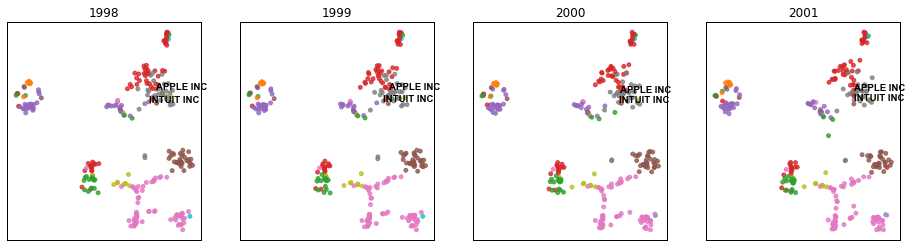

In [14]:
draw_map_sequence(Y_ts[:4], time_labels = years, 
                  c = sic_codes, labels = names, highlight_labels = ['APPLE INC', 'INTUIT INC'])

<a id = 'dynamic_map'></a>
### Draw a Dynamic Map

The third option - and often the most interesting one - is to explore all periods jointly via a *dynamic map* (i.e., an overlay of multiple subsequent maps). To do so, use ```draw_dynamic_map()``` as follows:

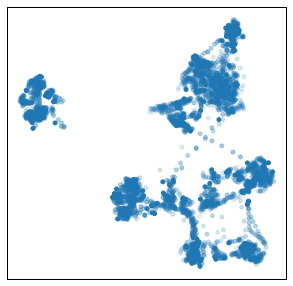

In [15]:
from evomap.printer import draw_dynamic_map

draw_dynamic_map(Y_ts)

```draw_dynamic_map()``` also provides some options to reveal the individual trajectories of each firm:

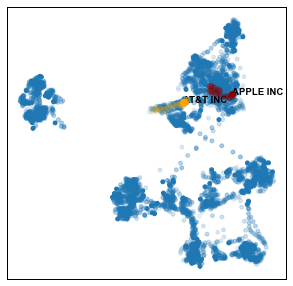

In [16]:
draw_dynamic_map(Y_ts, show_arrows = True, show_last_positions_only = False, 
                 labels = names, highlight_trajectories = ['APPLE INC', 'AT&T INC'])

As the last example shows, all arguments for ```draw_map()``` can also be passed to ```draw_dynamic_map()``` as keyword arguments to control the resultant map's aesthetics. Naturally, the arguments of both functions can also be combined arbitrarily (for instance, highlighting labels for same objects, while highlighting the trajectories of others): 

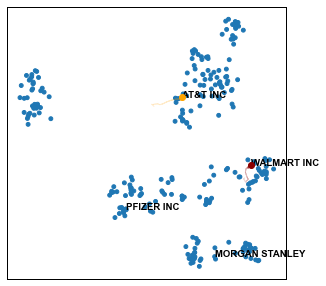

In [17]:
draw_dynamic_map(Y_ts, show_arrows = True, show_last_positions_only= True, highlight_trajectories = ['WALMART INC', 'AT&T INC'],
                 labels = names, highlight_labels = ['PFIZER INC', 'MORGAN STANLEY'])

Besides drawing the full map, one can also focus on individual firms and their trajectories. To do so, the dedicated function 

```draw_trajectories()``` 

is available. 

Besides map coordinates and labels (e.g., firm names), this function expects you to provide a list (or array) of focus firms, for which the trajectories should be displayed:

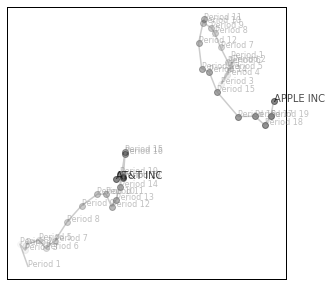

In [18]:
from evomap.printer import draw_trajectories
focus_firms = [
    'AT&T INC', 
    'APPLE INC']    
draw_trajectories(Y_ts, labels = names, selected_labels = focus_firms)

To ease interpretation, annotations for all periods can be added explicitly:

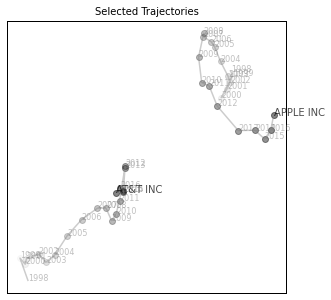

In [19]:
draw_trajectories(Y_ts, labels = names, selected_labels = focus_firms, title_str = "Selected Trajectories", period_labels = years)

<a id = 'section_4'></a>
## Evaluating Model Output

How "good" are these maps (e.g., how well do they fit the input data? How well do they reveal underyling changes?)? 

To answer this question, the following metrics are available. All functions are located within the 'metrics' module.


| Metric | Description | Function | Computed for | 
| --- | --- | --- | --- |
| Hitrate | Nearest neighbor recovery (in %) | ```hitrate_score()``` | Single Map| 
| Adjusted Hitrate | Hitrate, adjusted for random agreement | ```adjusted_hitrate_score()``` | Single Map |
| Avg. Hitrate | Avgerage Hitrate | ```avg_adjusted_hitrate_score()``` | Sequence of Maps |
| Avg. Adjusted Hitrate | Adjusted Hitrate, averaged across subsequent maps | ```avg_adjusted_hitrate_score()``` | Sequence of Maps |
| Misalignment | Average Distance of subsequent map positions  | ```misalign_score()```  | Sequence of Maps |
| Alignment | Cosine similarity of subsequent map positions | ```align_score()``` | Sequence of Maps |
| Persistence | Autocorrelation coeff. of first differences <br> of objects' subsequent map positions | ```persistence_score()``` | Sequence of Maps |



In [20]:
from evomap.metrics import avg_hitrate_score, misalign_score, persistence_score

In [21]:
df_eval = pd.DataFrame({
    'Avg Hitrate': avg_hitrate_score(D_ts, Y_ts, input_type = 'distance'),
    'Misalignment': misalign_score(Y_ts),
    'Persistence': persistence_score(Y_ts)
}, index = ['EvoMap'])

df_eval

,Avg Hitrate,Misalignment,Persistence
EvoMap,0.643764,0.014334,0.586008


To benchmark these values, we apply t-SNE independently to each distance matrix.

In [22]:
from sklearn.manifold import TSNE

Y_ts_indep = []
tsne_model = TSNE(
    n_components= 2, 
    perplexity = 25,
    init = Y_init,
    verbose = 0,
    learning_rate = 'auto',
    n_iter = 2000,
    method = 'exact',
    square_distances = True, # set to true to silence FutureWarning
    metric= 'precomputed')

for t in range(n_periods):
    tsne_results = tsne_model.fit_transform(D_ts[t])
    Y_ts_indep.append(tsne_results)

In [23]:
df_eval = pd.concat((df_eval, pd.DataFrame({
    'Avg Hitrate': avg_hitrate_score(D_ts, Y_ts_indep, input_type = 'distance'),
    'Misalignment': misalign_score(Y_ts_indep),
    'Persistence': persistence_score(Y_ts_indep)
}, index = ['Indep. TSNE'])), axis = 0)
df_eval

,Avg Hitrate,Misalignment,Persistence
EvoMap,0.643764,0.014334,0.586008
Indep. TSNE,0.615836,1.036111,-0.459960


<AxesSubplot:>

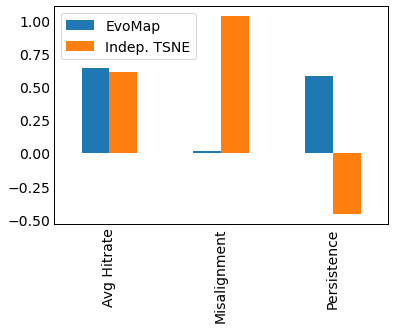

In [24]:
df_eval.T.plot(kind = 'bar')

<a id = 'section_5'></a>
## Hyperparameter Selection: 

The metrics introduced in the last section are well suited to tune EvoMap's hyperparameters. 

Specifically, there are two hyperparameters one needs to set when applying EvoMap: 

- alpha (float): Controls the degree of alignment 
- p (int): Controls the degree of smoothing

'Good' values for these parameters naturally depend on the given input data, one should always test multiple values for them and compare their results visually and quantitatively (e.g., using the metrics introduced in the previous section). 

To make such comparisons as easy as possible, EvoMap features a  ```grid_search()``` function. Given some input data and a grid of parameter values, this function creates a map sequence for each parameter combination and summarizes the results. 

First, define the parameter grid as a dictionary. For a start, its always good to define a broad range (which can later be narrowed down more closely): 

In [25]:
param_grid = {
    'alpha': [0.00000001, 0.000001, 0.00001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5], 
    'p': [1,2,3]}

Then, initialize the model and start the grid search:

In [ ]:
model = EvoTSNE(verbose = 2, init = Y_init_ts)

df_grid_results = model.grid_search(param_grid, D_ts)

[EvoTSNE] Evaluating parameter grid..
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-07, 'p': 1}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-07, 'p': 2}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-07, 'p': 3}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-06, 'p': 1}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-06, 'p': 2}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-06, 'p': 3}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-05, 'p': 1}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-05, 'p': 2}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-05, 'p': 3}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 0.0001, 'p': 1}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 0.0001, 'p': 2}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 0.0001, 'p': 3}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 0.001, 'p': 1}
[EvoTSNE] .. evaluating

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,7))

sns.barplot(x = 'alpha', y = 'static_cost', hue = 'p', data = df_grid_results, ax = ax[0])
sns.barplot(x = 'alpha', y = 'misalign_norm', hue = 'p', data = df_grid_results, ax = ax[1])
sns.barplot(x = 'alpha', y = 'pers', hue = 'p', data = df_grid_results, ax = ax[2])

Based on this evaluation, one can select suitable parameter combinations and inspect them further visually. 

Here, alpha = 0.001 and p = 3 seem reasonable. To use them, either create a new model instance or use the ```set_params()``` function to override the parameters of an existing model instance.

In [ ]:
Y_t = model.set_params({'alpha': 0.001, 'p': 3}).fit_transform(D_ts)

In [ ]:
draw_dynamic_map(Y_t, c = sic_codes)

In [ ]:
focus_firms = [
    'AT&T INC', 
    'APPLE INC']

draw_trajectories(Y_t, labels = names, selected_labels = focus_firms, 
                  title_str = "Selected Trajectories (after tuning)", period_labels = years)

As with any unsupervised learning technique, tuning these maps is both science and art. As there typically is no ground-truth known, it is typically impossible to objectively identify a single best solution. Instead, the grid results should serve as a basis to identify suitable values, from which you should always compare different solutions.    

<a id = 'section_6'></a>

## Choosing a Different Mapping Method

Thus far, this tutorial only used a single mapping method (t-SNE). While t-SNE works particularly well for large datasets, it has certain properties that make it less suitable for smaller datasets (e.g., map positions are estimated based on nearest neighborhood probabilities, rather than the actual input distances). 

In such (and other) cases, Multidimensional Scaling (MDS) and its variants might be the preferred choice. Therefore, we also provide an implementation of EvoMap for MDS: ```EvoMDS()```

For this demonstration, let's first pick a smaller sample:

In [ ]:
sample_firms = [
    'US CELLULAR CORP', 
    'AT&T INC', 
    'MICROSOFT CORP', 
    'WESTERN DIGITAL CORP', 
    'ORACLE CORP', 
    'EBAY INC', 
    'INTUIT INC', 
    'APPLE INC'] 

df_sample = df_tnic.query('name1 in @sample_firms').query('name2 in @sample_firms')

D_ts, names, years = build_distance_matrices(df_sample)
n_samples = D_ts[0].shape[0]
n_periods = len(D_ts)

Note that MDS does not transform the input distances in any way, but rather tries to fit map positions to them as closely as possible. Therefore, always make sure that your input distances are on a reasonable scale. If input distances are very large, for instance, gradient norms can quickly explode and it can become challenging to reach a good solution. Normalizing the input distances to a smaller range can help to avoid such cases and does not affect the resultant maps up to scaling their coordinate system. Make sure, however, to normalize each distance matrix in the sequence by the same factor!

In [ ]:
from evomap.transformations import normalize_distances
D_ts_norm = normalize_distances(D_ts)

Running EvoMap for MDS follows the same syntax as running it for t-SNE. Note, however, that some arguments for both classes differ, as they use different optimization routines. 

**Note:** MDS optimizes a different static cost function than t-SNE (Stress, rather than KL Divergence). As the output of these functions are scaled differently, 'good' values for the hyperparamters can (and often will) differ. Thus, make sure to run the grid search for MDS separately.  

In [ ]:
from evomap.EvoMDS import EvoMDS

param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10], 
    'p': [1,2]}

model_MDS = EvoMDS(
    verbose = 2, n_inits = 1)

df_res = model_MDS.grid_search(param_grid, D_ts_norm)

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,7))

sns.barplot(x = 'alpha', y = 'static_cost', hue = 'p', data = df_res, ax = ax[0])
sns.barplot(x = 'alpha', y = 'misalign_norm', hue = 'p', data = df_res, ax = ax[1])
sns.barplot(x = 'alpha', y = 'pers', hue = 'p', data = df_res, ax = ax[2])

From this graph, alpha = 1 and p = 2 seem reasonable. For higher values of alpha, p would need to be decreased to 1 (as otherwise static cost rises substantially). For alpha = 1 and p = 2, misalignment is small (below 10%) and persistence is high (> 80%). 

In [ ]:
model_MDS.set_params({'alpha': 1, 'p': 2})
Y_ts_MDS = model_MDS.fit_transform(D_ts)

In [ ]:
draw_dynamic_map(Y_ts_MDS, show_arrows = True)

In [ ]:
draw_trajectories(Y_ts_MDS, labels = names, title_str = "Selected Trajectories (MDS; after tuning)", period_labels = years)

<a id = 'section_7'></a>
## Special Cases, Extensions and Troubleshooting

### Inclusions / Exclusions
<a id = "inclusions"></a>

### Optimization Settings